# **Notebook 2: BERT**

In [1]:
# Install dependencies
!pip install pandas numpy scikit-learn tensorflow transformers matplotlib seaborn

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
import os

In [3]:
# Set paths
train_path = '/content/drive/MyDrive/dataset-sm/train.csv'
val_path = '/content/drive/MyDrive/dataset-sm/validation.csv'
test_path = '/content/drive/MyDrive/dataset-sm/test.csv'

In [4]:
# Load datasets
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

# --- Step 1: Exploratory Data Analysis (EDA) ---

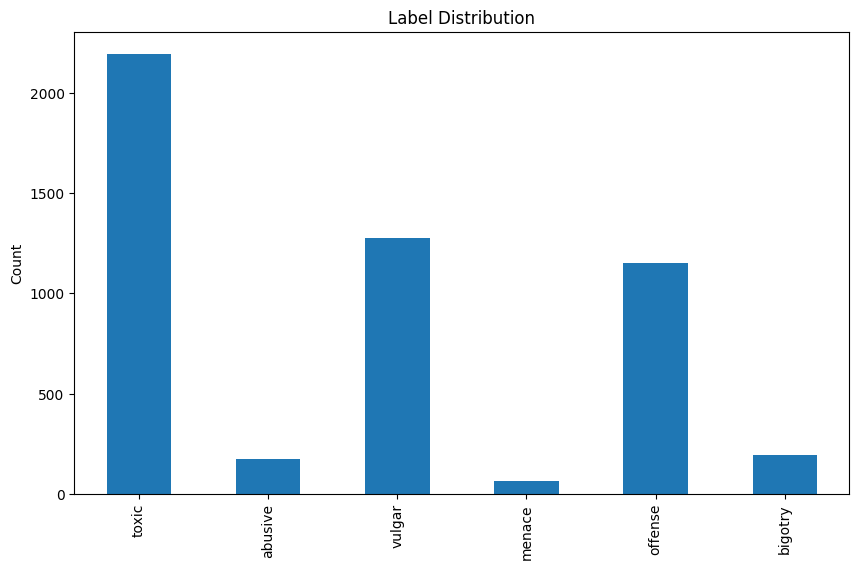

In [5]:
# Label distribution
labels = ['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']
plt.figure(figsize=(10, 6))
train_df[labels].sum().plot(kind='bar')
plt.title('Label Distribution')
plt.ylabel('Count')
plt.savefig('/content/drive/MyDrive/label_distribution_bert.png')
plt.show()

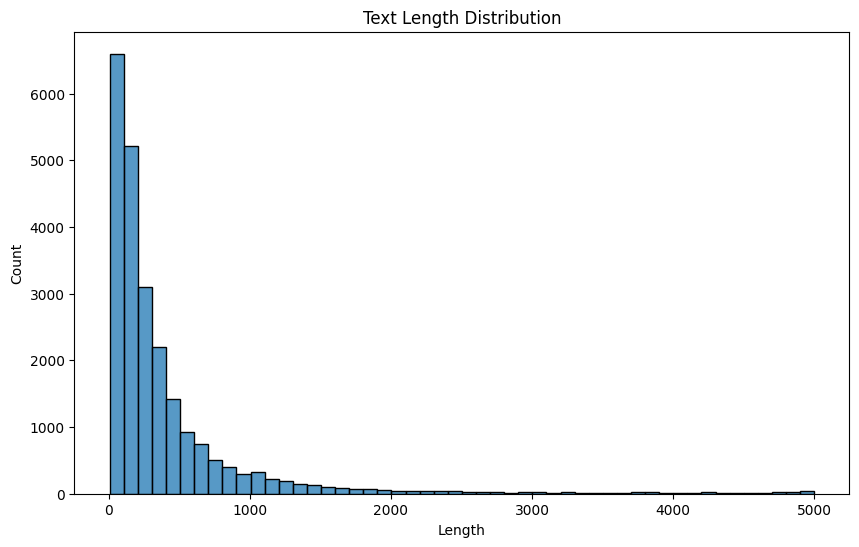

In [6]:
# Text length distribution
train_df['text_length'] = train_df['feedback_text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(train_df['text_length'], bins=50)
plt.title('Text Length Distribution')
plt.xlabel('Length')
plt.savefig('/content/drive/MyDrive/text_length_bert.png')
plt.show()

In [7]:
# Check for missing values
print("Missing Values:\n", train_df.isnull().sum())

Missing Values:
 id               0
feedback_text    0
toxic            0
abusive          0
vulgar           0
menace           0
offense          0
bigotry          0
text_length      0
dtype: int64


# --- Step 2: Text Preprocessing for BERT ---

In [8]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [9]:
# Custom Dataset class
class ToxicDataset(Dataset):
    def __init__(self, texts, labels=None):
        self.texts = texts
        self.labels = labels
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='pt')

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

In [10]:
# Prepare datasets
train_dataset = ToxicDataset(train_df['feedback_text'].tolist(), train_df['toxic'].tolist())
val_dataset = ToxicDataset(val_df['feedback_text'].tolist(), val_df['toxic'].tolist())
test_dataset = ToxicDataset(test_df['content'].tolist())

# --- Step 3: BERT Model ---

In [11]:
# Initialize model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Training arguments
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/bert_results',
    run_name="bert_toxic_classification",  # Unique run name to avoid warning
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='/content/drive/MyDrive/bert_logs',
    logging_steps=10,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    report_to="none"  # Disable W&B logging
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda p: {
        'accuracy': accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1)),
        'precision': precision_score(p.label_ids, np.argmax(p.predictions, axis=1)),
        'recall': recall_score(p.label_ids, np.argmax(p.predictions, axis=1)),
        'f1': f1_score(p.label_ids, np.argmax(p.predictions, axis=1)),
    }
)

In [14]:
# Train model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.230600,0.600075,0.836905,0.434783,0.074627,0.127389
2,0.136600,0.491989,0.846429,1.000000,0.037313,0.071942
3,0.127600,0.663429,0.855952,0.933333,0.104478,0.187919


TrainOutput(global_step=4404, training_loss=0.15848413874631195, metrics={'train_runtime': 1915.6887, 'train_samples_per_second': 36.759, 'train_steps_per_second': 2.299, 'total_flos': 4632004351848960.0, 'train_loss': 0.15848413874631195, 'epoch': 3.0})

# --- Step 4: Model Evaluation ---

In [15]:
# Predict on validation set
val_preds = trainer.predict(val_dataset)
y_pred_bert = np.argmax(val_preds.predictions, axis=1)
y_val = val_preds.label_ids

In [16]:
# Metrics
print("BERT Metrics:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_bert):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_bert):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_bert):.4f}")
print(f"F1-Score: {f1_score(y_val, y_pred_bert):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_val, val_preds.predictions[:, 1]):.4f}")

BERT Metrics:
Accuracy: 0.8464
Precision: 1.0000
Recall: 0.0373
F1-Score: 0.0719
AUC-ROC: 0.8296


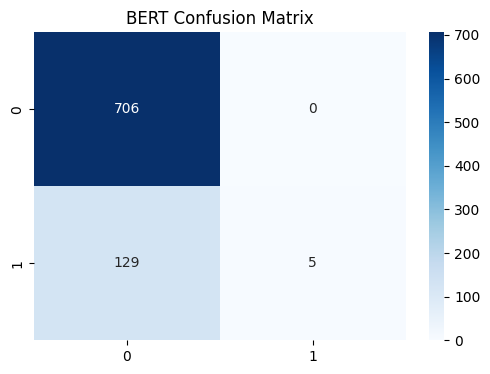

In [17]:
# Confusion Matrix
cm_bert = confusion_matrix(y_val, y_pred_bert)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues')
plt.title('BERT Confusion Matrix')
plt.savefig('/content/drive/MyDrive/cm_bert.png')
plt.show()

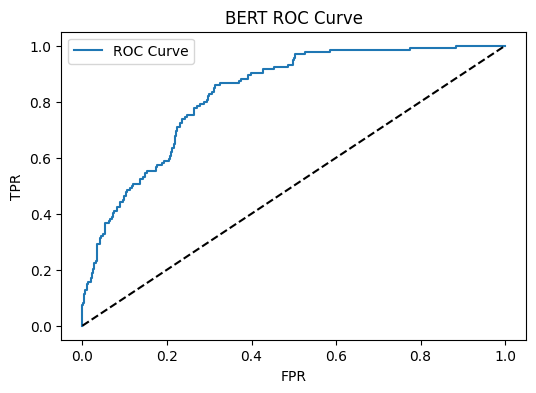

In [18]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_val, val_preds.predictions[:, 1])
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('BERT ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.savefig('/content/drive/MyDrive/roc_bert.png')
plt.show()

# --- Step 5: Model Tuning ---

In [19]:
# Tuned training arguments
tuned_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/bert_results_tuned',
    run_name="bert_toxic_classification_tuned",  # Unique run name
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='/content/drive/MyDrive/bert_logs_tuned',
    logging_steps=10,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    report_to="none"  # Disable W&B logging
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [20]:
# Initialize tuned Trainer
tuned_trainer = Trainer(
    model=model,
    args=tuned_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda p: {
        'f1': f1_score(p.label_ids, np.argmax(p.predictions, axis=1)),
    }
)

In [21]:
# Train tuned model
tuned_trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.238100,0.608343,0.014706
2,0.360000,0.449649,0.000000
3,0.449100,0.494427,0.000000
4,0.354600,0.478574,0.000000


TrainOutput(global_step=11740, training_loss=0.26504800673859796, metrics={'train_runtime': 2797.4256, 'train_samples_per_second': 33.564, 'train_steps_per_second': 4.197, 'total_flos': 6176005802465280.0, 'train_loss': 0.26504800673859796, 'epoch': 4.0})

# --- Step 6: Predictions on Test Data ---

In [22]:
# Predict on test set
test_preds = trainer.predict(test_dataset)
test_pred_bert = np.argmax(test_preds.predictions, axis=1)
submission_bert = pd.DataFrame({'id': test_df['id'], 'toxic': test_pred_bert})
submission_bert.to_csv('/content/drive/MyDrive/submission_bert.csv', index=False)

In [23]:
# Save model
trainer.save_model('/content/drive/MyDrive/bert_model')